In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow import keras 

# For testing
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

In [2]:
# Global Constants
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
CHANNELS = 3
BATCH_SIZE = 2
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

# File Paths
image_path = os.path.join("data", "images")
mask_path = os.path.join("data", "masks")

## The arguments for keras image data generator functions
# For the training and validation sets
TRAIN_ARGS = dict(
    rescale=1.0/255,        # Rescaling factor, applied after all other transformations
    shear_range=0.1,        # Shear the Image by 10%
    zoom_range=0.1,         # Zoom in or out by 10%
    horizontal_flip=True,   # Randomly flip horizontally
    vertical_flip=True,     # Randomly flip vertically
    fill_mode='nearest',    # Fill gaps with nears pixel
    validation_split=0.2)   # Reserve 20% for 'validation'

# For the testing split
TEST_ARGS = dict(
    rescale=1.0/255,        # Rescaling factor, applied after all other transformations
    validation_split=0.8)   # Reserve 80% for 'validation' (training)

# Arguments for the flow from directory function call
IMAGE_LOAD_ARGS = dict(
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    interpolation="nearest",
    subset='training',
    class_mode=None,
    seed=42
    ) 

In [3]:
# A function that loads the images, splits into train/test segments, applies transformations detail in constants above
# It returns a joined and batched version of the training data (image,mask) and a joined version of the test data (image,mask)
# Each 'image' in image_train, mask_train, image_test, and mask_test will contain the number of images specified in BATCH_SIZE
def pre_processing():
    # Create image data generator that applies the data augmentation detailed in constants
    train_image_generator = keras.preprocessing.image.ImageDataGenerator(**TRAIN_ARGS)
    train_mask_generator = keras.preprocessing.image.ImageDataGenerator(**TRAIN_ARGS)
    test_image_generator = keras.preprocessing.image.ImageDataGenerator(**TEST_ARGS)
    test_mask_generator = keras.preprocessing.image.ImageDataGenerator(**TEST_ARGS)
    
    # Load test/train data through the respective data generator
    # Training data 
    image_train = train_image_generator.flow_from_directory(
        directory=image_path,
        color_mode="rgb",
        **IMAGE_LOAD_ARGS)
    
    # Training Mask Data
    mask_train = train_mask_generator.flow_from_directory(
        directory=mask_path,
        color_mode="grayscale",
        **IMAGE_LOAD_ARGS)
    
    
    # Test Data
    image_test = test_image_generator.flow_from_directory(
        directory=image_path,
        color_mode="rgb",
        **IMAGE_LOAD_ARGS)
    
    # Test Mask Data
    mask_test = test_mask_generator.flow_from_directory(
        directory=mask_path,
        color_mode="grayscale",
        **IMAGE_LOAD_ARGS)

    # Return a joined version of the training data (image,mask) and a joined version of the test data (image,mask)
    return zip(image_train, mask_train), zip(image_test, mask_test)
    
def dice_coefficient(truth, predicted):
    numerator = 2 * tf.reduce_sum(true*predicted)
    denominator = tf.reduce_sum(true) tf.reduce_sum(predicted)
    # Axis integration etc

In [4]:
train,test = pre_processing()

Found 2076 images belonging to 1 classes.
Found 2076 images belonging to 1 classes.
Found 519 images belonging to 1 classes.
Found 519 images belonging to 1 classes.


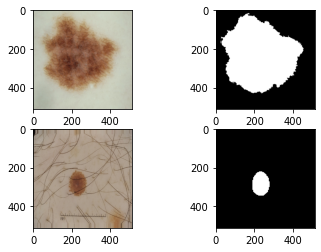

In [5]:

for batch in train:
    fig, axs = plt.subplots(2, 2)
    axs[0,0].imshow(batch[0][0])
    axs[0,1].imshow(batch[1][0], cmap='Greys_r')
    axs[1,0].imshow(batch[0][1])
    axs[1,1].imshow(batch[1][1], cmap='Greys_r')
    plt.show()
    
    break

In [6]:
# Constants
INSTANCE_NORMALIZATION_ARGS = dict(
    axis=3,                             # Axis being normalised
    center=True,                        # Signal to add beta as an offset to the normalised tensor
    scale=True,                         # Signal to multiply by gamma
    beta_initializer='random_uniform',  
    gamma_initializer='random_uniform') 

LEAKY_ALPHA = 0.01
# Optimiser Information

In [7]:
def context_module(input, out_filter):
    # First Convolution block
    c1 = Conv2D(filters=out_filter, kernel_size=(3,3), padding='same')(input)
    c2 = tfa.layers.InstanceNormalization(**INSTANCE_NORMALIZATION_ARGS)(c1)
    c3 = LeakyReLU(alpha=LEAKY_ALPHA)(c2)
    
    # DropOut
    c4 = Dropout(0.3)(c3)
    
    # Secound Convolution block
    c5 = Conv2D(filters=out_filter, kernel_size=(3,3), padding='same')(c4)
    c6 = tfa.layers.InstanceNormalization(**INSTANCE_NORMALIZATION_ARGS)(c5)
    c7 = LeakyReLU(alpha=LEAKY_ALPHA)(c6)
    
    # Preactivation residual add
    c8 = Add()([input,c7])
    
    return c8

# Module that recombines the features following concatenation and reduces the number of feature maps for memory
def localization_module(input, out_filter):
    # First Convolution block
    l1 = Conv2D(filters=out_filter, kernel_size=(3,3), padding='same')(input)
    l2 = tfa.layers.InstanceNormalization(**INSTANCE_NORMALIZATION_ARGS)(l1)
    l3 = LeakyReLU(alpha=LEAKY_ALPHA)(l2)
    
    # Secound Convolution block, of shape (1x1x1)
    l4 = Conv2D(filters=out_filter, kernel_size=(1,1), padding='same')(l3)
    l5 = tfa.layers.InstanceNormalization(**INSTANCE_NORMALIZATION_ARGS)(l4)
    l6 = LeakyReLU(alpha=LEAKY_ALPHA)(l5)
    
    return l6

# Upsamples features from a lower 'level' of the UNet to a higher spatial information
def upsampling_module(input, out_filter):
    # Upsample 
    u1 = UpSampling2D(size=(2, 2))(input)
    
    # Convolutional block
    u2 = Conv2D(filters=out_filter, kernel_size=(3,3), padding='same')(u1)
    u3 = tfa.layers.InstanceNormalization(**INSTANCE_NORMALIZATION_ARGS)(u2)
    u4 = LeakyReLU(alpha=LEAKY_ALPHA)(u3)
    
    return u4

# Connects context_modueles to reduce the resolution of the feature maps and allow for more features while aggregating
def context_connector(input, out_filter):
    cc1 = Conv2D(filters=out_filter, kernel_size=(3,3), strides=2, padding='same')(input)
    cc2 = tfa.layers.InstanceNormalization(**INSTANCE_NORMALIZATION_ARGS)(cc1)
    cc3 = LeakyReLU(alpha=LEAKY_ALPHA)(cc2)
    return cc3

In [8]:
def improved_unet(input_size = (512,512,3)):
    input = Input(shape=input_size)
    
    # Context Pathway
    # Layer 1
    x1 = Conv2D(filters=16, kernel_size=(3,3), padding='same')(input)
    x2 = tfa.layers.InstanceNormalization(**INSTANCE_NORMALIZATION_ARGS)(x1)
    x3 = LeakyReLU(alpha=LEAKY_ALPHA)(x2) 
    x4 = context_module(x3, 16)
    
    # Layer 2
    x5 = context_connector(x4, 32)
    x6 = context_module(x5, 32)
    
    # Layer 3
    x7 = context_connector(x5, 64)
    x8 = context_module(x7, 64)
    
    # Layer 4
    x9 = context_connector(x8, 128)
    x10 = context_module(x9, 128)
    
    # Layer 5.1
    x11 = context_connector(x10, 256)
    x12 = context_module(x11, 256)
    
    # Begin Localization Pathway
    # Layer 5.2
    x13 = upsampling_module(x12, 128)
    
    # Layer 4
    x14 = Concatenate()([x10, x13])
    x15 = localization_module(x14, 128)
    x16 = upsampling_module(x15, 64)
    
    # Layer 3
    x17 = Concatenate()([x8, x16])
    x18 = localization_module(x17, 64) # Segmentation 1 from here
    x19 = upsampling_module(x18, 32)
    
    # Layer 3: Segmentation
    seg1 = Activation('sigmoid')(x18)
    seg1 = upsampling_module(seg1, 32)
    
    # Layer 2
    x20 = Concatenate()([x6, x19])
    x21 = localization_module(x20, 32) # Segmentation 2 from here
    x22 = upsampling_module(x21, 16)
    
    # Layer 2: Segmentation
    seg2 = Activation('sigmoid')(x21)
    seg3 = Add()([seg1,seg2])
    seg3 = upsampling_module(seg3, 32)
    
    # Layer 1
    x23 = Concatenate()([x4, x22])
    x24 = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x23)
    x25 = tfa.layers.InstanceNormalization(**INSTANCE_NORMALIZATION_ARGS)(x24)
    x26 = LeakyReLU(alpha=LEAKY_ALPHA)(x25) 
    
    # Layer 1: Segmentation
    seg4 = Activation('sigmoid')(x26)
    segFinal = Add()([seg3,seg4])
    
    # Output
    output = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid', padding='same')(segFinal)
    
    uNet = Model(inputs=input, outputs=output)
    return uNet
    
    # Run multpile epochs with softmax overnight (20 should do)

In [9]:
model = improved_unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics='Accuracy')


In [10]:
training = model.fit(
    train,
    steps_per_epoch=1039,
    epochs=1,
    shuffle=True,
    verbose=1,
    use_multiprocessing=False)

1039/1039 [==============================] - 191s 174ms/step - loss: 0.4554 - accuracy: 0.0000e+00


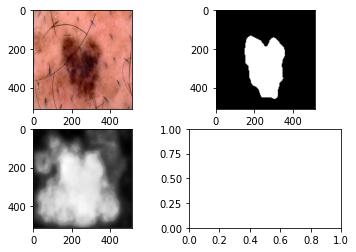

In [13]:
for batch in test:
    prediction = model.predict(batch[0])
    fig, axs = plt.subplots(2, 2)
    axs[0,0].imshow(batch[0][0])
    axs[0,1].imshow(batch[1][0], cmap='gray')
    axs[1,0].imshow(prediction[0], cmap='gray')
    plt.show()
    break

In [14]:
print(prediction[0])

[[[0.19509836]
  [0.15405548]
  [0.13642707]
  ...
  [0.11261766]
  [0.1066763 ]
  [0.1362196 ]]

 [[0.16218539]
  [0.12020928]
  [0.10362875]
  ...
  [0.08718363]
  [0.07947668]
  [0.11231451]]

 [[0.14905807]
  [0.10377401]
  [0.09491171]
  ...
  [0.09111738]
  [0.08666105]
  [0.12485958]]

 ...

 [[0.1281938 ]
  [0.08978088]
  [0.08972644]
  ...
  [0.10386091]
  [0.11532044]
  [0.16100124]]

 [[0.12656668]
  [0.09016174]
  [0.09292269]
  ...
  [0.11477564]
  [0.13256483]
  [0.17644902]]

 [[0.15627779]
  [0.12704019]
  [0.12847194]
  ...
  [0.14806585]
  [0.16399254]
  [0.17251496]]]
